In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import time

from pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV as GS

from sklearn.metrics import average_precision_score, make_scorer
from sklearn.metrics import fbeta_score

%matplotlib inline
rcParams['figure.figsize'] = 6, 4
warnings.filterwarnings('ignore')
sns.set(style= 'whitegrid')

# D) Optimisation du meilleur modèle  

    - création de la fonction coût 
    - Fine Tuning des hyperparamètres du modèle choisi
    
    
    

In [2]:
# récupération du fichier après Analyse Exploratoire et Feature Engineering

df = pd.read_csv('df_final.csv', sep=',')

In [3]:
# Préparation du jeu d'entraînement et du jeu de test

X = df.loc[:, df.columns != 'TARGET']
Y = df.loc[:, df.columns == 'TARGET']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.3, random_state=50)

In [4]:
Y_train['TARGET'].value_counts()

0.0    197835
1.0     17419
Name: TARGET, dtype: int64

In [5]:
spw = 197835/17419

In [6]:
model = LGBMClassifier(objective='binary', scale_pos_weight = spw, max_depth= 3, n_estimators= 500)

# Entraînement
model.fit(X_train, Y_train)

LGBMClassifier(max_depth=3, n_estimators=500, objective='binary',
               scale_pos_weight=11.357425799414433)

In [7]:
# Prédiction sur le jeu de test
Y_test_pred = model.predict(X_test)

In [8]:
Y_pred=model.predict(X_test)
scoref2b= fbeta_score(y_true=Y_test, y_pred=Y_pred,beta=2)
scoref2b

0.4400333872398143

              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83     84847
         1.0       0.18      0.68      0.29      7406

    accuracy                           0.73     92253
   macro avg       0.57      0.71      0.56     92253
weighted avg       0.90      0.73      0.79     92253



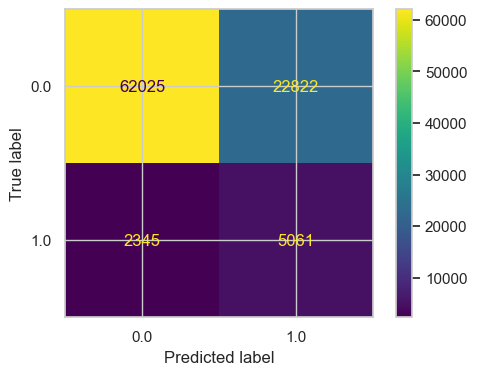

In [9]:
print(classification_report(Y_test, Y_test_pred))
cm = confusion_matrix(Y_test, Y_test_pred, labels=model.classes_)
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model.classes_).plot()
plt.show()

Recall 0.68 pour les faux Négatifs. Il faut maximiser ce score et, dans l'idéal, essayer de diminuer les faux positifs

In [10]:
import optuna
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.3, random_state=50)

def objective(trial):
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 300, 800),
        'num_leaves' : trial.suggest_int('num_leaves', 10, 50),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'reg_alpha': trial.suggest_discrete_uniform('reg_alpha', 0, 1, 0.1),
        'reg_lambda': trial.suggest_discrete_uniform('reg_lambda', 0, 1, 0.1),  
        'learning_rate':trial.suggest_discrete_uniform('learning_rate', 0.1, 0.6, 0.01), 
         }
    
    optuna_model = LGBMClassifier(scale_pos_weight = spw, random_state=123,**param )
    optuna_model.fit(X_train, Y_train)
    Y_pred=optuna_model.predict(X_test)
    scoref2b= fbeta_score(y_true=Y_test, y_pred=Y_pred,beta=2)
    return scoref2b

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2022-12-21 15:25:20,073] A new study created in memory with name: no-name-818935fd-2a18-446d-8856-024a681ead34
[I 2022-12-21 15:25:43,136] Trial 0 finished with value: 0.4048122256543651 and parameters: {'n_estimators': 345, 'num_leaves': 45, 'max_depth': 5, 'reg_alpha': 0.9, 'reg_lambda': 0.8, 'learning_rate': 0.28}. Best is trial 0 with value: 0.4048122256543651.
[I 2022-12-21 15:26:25,973] Trial 1 finished with value: 0.23674140347094966 and parameters: {'n_estimators': 583, 'num_leaves': 41, 'max_depth': 6, 'reg_alpha': 0.9, 'reg_lambda': 0.0, 'learning_rate': 0.59}. Best is trial 0 with value: 0.4048122256543651.
[I 2022-12-21 15:26:44,430] Trial 2 finished with value: 0.4376621130900917 and parameters: {'n_estimators': 360, 'num_leaves': 36, 'max_depth': 3, 'reg_alpha': 0.1, 'reg_lambda': 0.8, 'learning_rate': 0.11}. Best is trial 2 with value: 0.4376621130900917.
[I 2022-12-21 15:27:08,960] Trial 3 finished with value: 0.35679117704982605 and parameters: {'n_estimators': 410,

In [11]:
model_compare = LGBMClassifier(objective='binary', scale_pos_weight = spw, n_estimators= 360, num_leaves= 36, 
                       max_depth= 3, reg_alpha= 0.1, reg_lambda= 0.8, learning_rate= 0.11)

# Entraînement
model_compare.fit(X_train, Y_train)

LGBMClassifier(learning_rate=0.11, max_depth=3, n_estimators=360, num_leaves=36,
               objective='binary', reg_alpha=0.1, reg_lambda=0.8,
               scale_pos_weight=11.357425799414433)

In [12]:
# Prédiction sur le jeu de test
Y_test_pred = model_compare.predict(X_test)

In [13]:
Y_pred=model_compare.predict(X_test)
scoref2b= fbeta_score(y_true=Y_test, y_pred=Y_pred,beta=2)
scoref2b

0.4380148163497901

              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83     84847
         1.0       0.18      0.68      0.28      7406

    accuracy                           0.72     92253
   macro avg       0.57      0.71      0.56     92253
weighted avg       0.90      0.72      0.78     92253



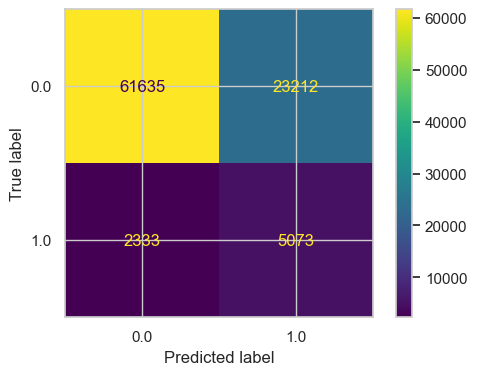

In [14]:
 #Show confusion matrix
print(classification_report(Y_test, Y_test_pred))
cm1 = confusion_matrix(Y_test, Y_test_pred, labels=model.classes_)
ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels=model.classes_).plot()
plt.show()

Le nombre de faux négatif est très légèrement inférieur pour ce nouveau modèle, mais le taux de faux positifs a augmenté de manière beaucoup plus significative; nous allons donc conserver le modèle initial qui affiche un équilibre entre faux posititif et faux négatif satisfaisant.

In [15]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))

# E) Analyse de la « feature importance » globale avec SHAP

In [16]:
import shap 
shap.initjs()  # chargement du code de visualisation JS

In [17]:
# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

Feature Importance - Global 

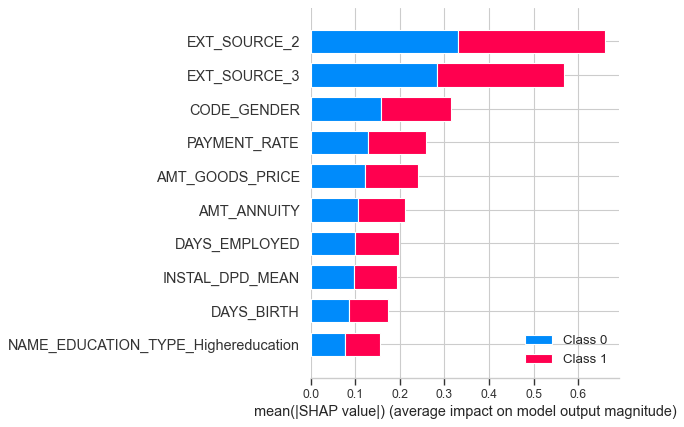

In [18]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
fig =shap.summary_plot(shap_values, X, plot_type='bar', max_display=10, show=False)
plt.savefig('grafic.png', bbox_inches = 'tight')

Analyse des principales features globales avec BOXPLOT - en écartant les outliers

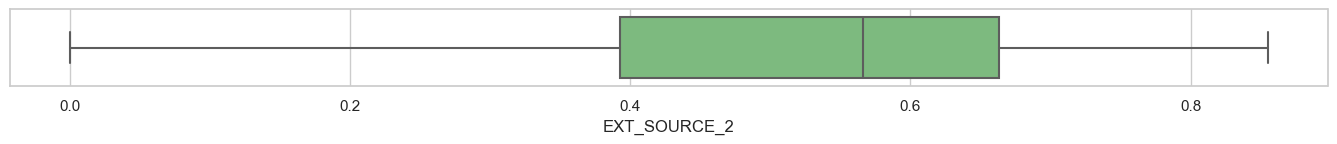

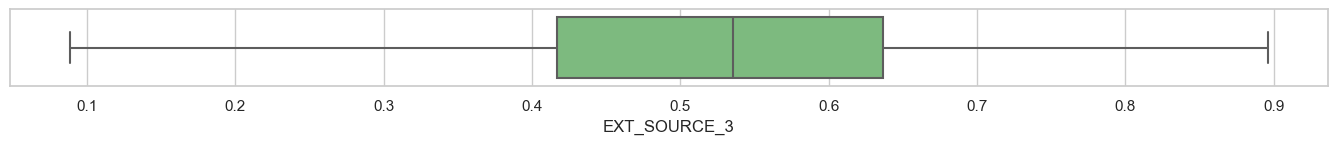

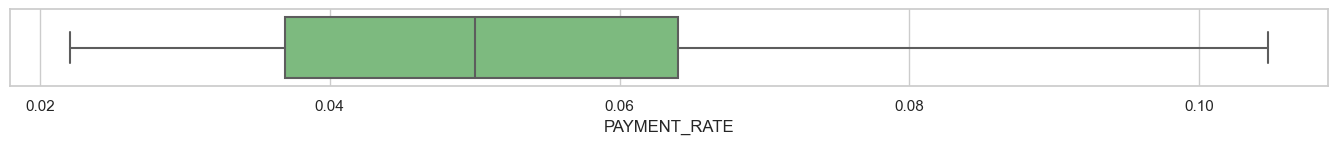

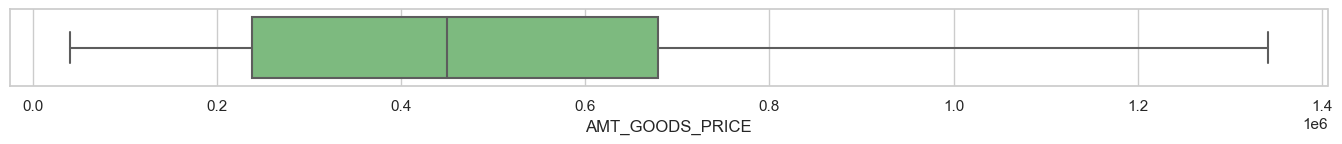

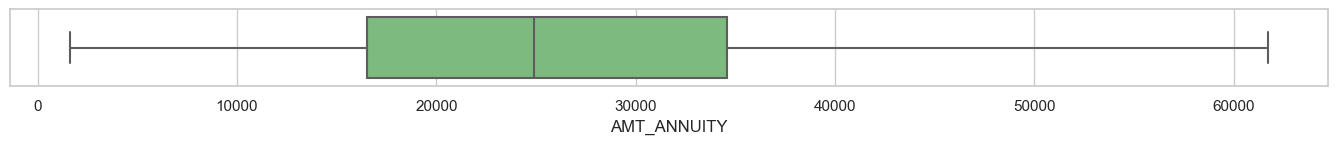

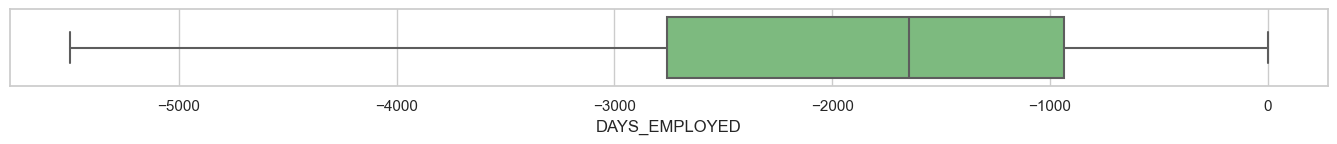

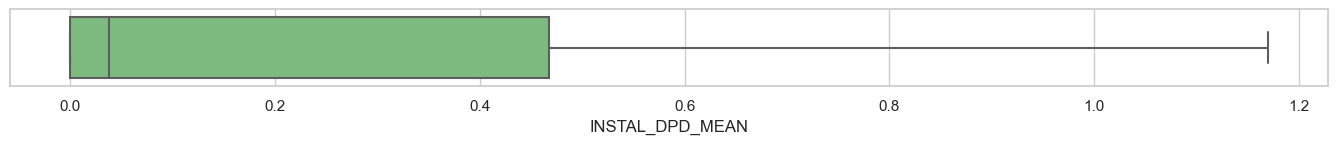

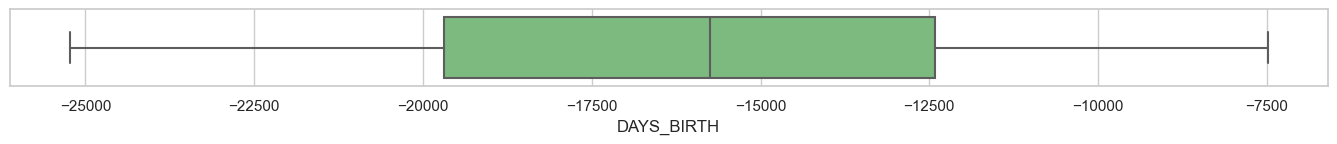

In [19]:
df_boxplot = df [['EXT_SOURCE_2','EXT_SOURCE_3','PAYMENT_RATE','AMT_GOODS_PRICE', 'AMT_ANNUITY',\
                      'DAYS_EMPLOYED','INSTAL_DPD_MEAN','DAYS_BIRTH']]

for column in df_boxplot :
        plt.figure(figsize=(17,1))
        sns.set_theme(style="whitegrid")
        sns.boxplot(data = df_boxplot, x=column, palette = 'Greens', showfliers=False)